# 2D FEL
# 初始化数据
## DF 
    - frame x y t 


In [88]:
import sys
import math
import pandas as pd
import numpy as np
import re
import argparse

from scipy import interpolate
from scipy.interpolate import RBFInterpolator
from scipy.interpolate import Rbf

from sklearn.cluster import KMeans
from skimage.feature import peak_local_max

from matplotlib import pyplot as plt
import matplotlib.colors as colors
np.set_printoptions(precision=6)

import heapq
import math

In [89]:
# 初始化数据
class Dat2D():
    def __init__(self, frame, x, y, t) -> None:
        self.frame = frame
        self.x = x
        self.y = y
        self.time = t

class MD2DDat():
    def __init__(self, fp, dt) -> None:
        self.frame = None
        self.x = None
        self.y = None
        self.time = None
        self.__ReadDat__(fp)
        self.__TimeSeries__(dt)

    def __TimeSeries__(self, dt):
        t = {"ps":[],"ns":[]}
        for i in self.frame:
            t["ps"].append(i*dt/1000)
            t["ns"].append(i*dt)
        self.time = np.array(t["ns"])

    def __ReadDat__(self, fp):
        dat = pd.read_csv(fp,sep = ",",header= None)
        self.frame = dat[0].to_numpy()
        self.x = dat[1].to_numpy()
        self.y = dat[2].to_numpy()
    
    # 此方法用于暴露类中的数据
    def values(self):
        var = Dat2D(self.frame, self.x, self.y, self.time)
        return var

In [90]:
"""
        # 用于储存落入网格中的frame信息
        frame = []
        count = 0
        x_var, y_var = np.array([]), np.array([])
        frame_var, time_var = np.array([]), np.array([])
        # 遍历寻找落在当前窗格的数据点个数
        for i, x in enumerate(self.mddat2d.x):
    
            if (mesh_x - dx <= x <   mesh_x + dx) and (mesh_y - dy <= self.mddat2d.y[i] <   mesh_y + dy) :
                count += 1
                # 添加符合要求的frame
                frame.append(self.mddat2d.frame[i])
            else:
                x_var = np.append(x_var,x)
                y_var = np.append(y_var,self.mddat2d.y[i])
                frame_var = np.append(frame_var,self.mddat2d.frame[i])
                time_var = np.append(time_var,self.mddat2d.time[i])
        # 删除统计过的数据点
        self.mddat2d.x = x_var
        self.mddat2d.y = y_var
        self.mddat2d.frame = frame_var
        self.mddat2d.time = time_var
""" 

'\n        # 用于储存落入网格中的frame信息\n        frame = []\n        count = 0\n        x_var, y_var = np.array([]), np.array([])\n        frame_var, time_var = np.array([]), np.array([])\n        # 遍历寻找落在当前窗格的数据点个数\n        for i, x in enumerate(self.mddat2d.x):\n    \n            if (mesh_x - dx <= x <   mesh_x + dx) and (mesh_y - dy <= self.mddat2d.y[i] <   mesh_y + dy) :\n                count += 1\n                # 添加符合要求的frame\n                frame.append(self.mddat2d.frame[i])\n            else:\n                x_var = np.append(x_var,x)\n                y_var = np.append(y_var,self.mddat2d.y[i])\n                frame_var = np.append(frame_var,self.mddat2d.frame[i])\n                time_var = np.append(time_var,self.mddat2d.time[i])\n        # 删除统计过的数据点\n        self.mddat2d.x = x_var\n        self.mddat2d.y = y_var\n        self.mddat2d.frame = frame_var\n        self.mddat2d.time = time_var\n'

In [91]:
class Mesh2D():
    def __init__(self, x_center,y_center,s,dx,dy, frame, Pmt) -> None:
        self.x = x_center
        self.y = y_center
        self.s = s
        self.dx = dx
        self.dy = dy
        self.frame = frame
        self.Pmt = Pmt
class GenPMatrix2D():

    def __init__(self, MD2DDat, xnum, ynum) -> None:
        self.mddat2d = MD2DDat.values()
        self.mesh2d = Mesh2D(*self.__GenMesh2D__(xnum, ynum), None, None)

    def __GenMesh2D__(self, xnum, ynum):
        x_min,x_max = self.mddat2d.x.min(), self.mddat2d.x.max()
        y_min,y_max = self.mddat2d.y.min(), self.mddat2d.y.max()
        dx = (x_max-x_min) / (2*xnum)
        dy = (y_max-y_min) / (2*ynum)
        x_center = np.array([])
        y_center = np.array([])
        func = lambda x,d,c0 : (2*x-1)*d + c0
        s = 2*dx*2*dy           
        for i in range(1,xnum+1):
            x_center = np.append(x_center,func(i,dx,x_min))
        for i in range(1,ynum+1):
            y_center = np.append(y_center,func(i,dy,y_min))
        return (x_center,y_center,s,dx,dy)
    
    def __fallW__(self, mesh_xi, mesh_yi):
        
        mesh_x = self.mesh2d.x[mesh_xi]
        mesh_y = self.mesh2d.y[mesh_yi]
        dx = self.mesh2d.dx
        dy = self.mesh2d.dy
        
        # 考虑通过bool索引
        # 构造DF
        XY = pd.DataFrame({"x":self.mddat2d.x, "y":self.mddat2d.y})
        XY_1 = XY[((mesh_x - dx) <= XY["x"]) & (XY["x"] < (mesh_x + dx)) & ((mesh_y - dy) <= XY["y"]) & (XY["y"] < (mesh_y + dy))]
        # 获取符合要求的与不符合要求的
        XY_1_index = set(XY_1.index.to_list())
        XY_0_index = set(XY.index.to_list()) - XY_1_index
        # 计数与统计构象
        count = len(XY_1_index)
        XY_1_index = list(XY_1_index)
        XY_0_index = list(XY_0_index)
        frame = self.mddat2d.frame[XY_1_index]
        # 更新数据集
        self.mddat2d.x = self.mddat2d.x[XY_0_index]
        self.mddat2d.y = self.mddat2d.y[XY_0_index]
        self.mddat2d.frame = self.mddat2d.frame[XY_0_index]
        self.mddat2d.time =  self.mddat2d.time[XY_0_index]
        return (count,frame)
        

    def Pmatrix(self):
        # 总采样点
        N = len(self.mddat2d.x)
        if not self.mesh2d.frame:
            # 概率密度矩阵
            self.mesh2d.Pmt = np.zeros(shape=[len(self.mesh2d.x),len(self.mesh2d.y)])

        # 创建dict储存采样网格原始frame信息，其中keys的格式为"i-j"
        if not self.mesh2d.frame:
            self.mesh2d.frame = {}
            print("")
            print("Ready to cal P")
            print("S_window={:.2f}\t\tN_total={}".format(self.mesh2d.s,N))

        for i in range(len(self.mesh2d.x)):
            for j in range(len(self.mesh2d.y)):
                fallWout = self.__fallW__(i,j)
                # 计算该点的概率密度
                P = fallWout[0] / (N*self.mesh2d.s)
                # 记录概率密度
                self.mesh2d.Pmt[i][j] = P
                # 记录每个点的采样构象
                self.mesh2d.frame["{}-{}".format(i,j)] = fallWout[1]

        print("Pmax-ori={},Pmin-ori={}".format(self.mesh2d.Pmt.max(),self.mesh2d.Pmt.min()))
        # 归一化
        tol_density = np.sum(self.mesh2d.Pmt)
        self.mesh2d.Pmt /=tol_density
        print("After Normalization, Pmax={},Pmin={}".format(self.mesh2d.Pmt.max(),self.mesh2d.Pmt.min()))
        print("")

In [92]:
# 峰值点
# 峰值点部分
# 注意，del需要在计算G之后调用，切记
class PPeak():
    def __init__(self,n_peak,mesh2d) -> None:
        self.x = []
        self.y = []
        self.mesh2d = mesh2d
        self.ij = np.flip(peak_local_max(self.mesh2d.Pmt,num_peaks=n_peak),axis =1)
        self.G = []
        self.__PeakXY__()
    def __PeakXY__(self):
        for i in range(self.ij.shape[0]):
            self.x.append(self.mesh2d.x[self.ij[i,0]])
            self.y.append(self.mesh2d.y[self.ij[i,1]])
    # 用于删除指定索引
    def delPeak(self,i_list):
        x, y, G = [], [], []
        ij = np.empty(shape=[0, 2],dtype="int")
        for i,x_ in enumerate(self.x):
            if i not in i_list:
                x.append(x_)
                y.append(self.y[i])
                G.append(self.G[i])
                ij = np.append(ij,values=[self.ij[i]], axis=0)
        self.x = x
        self.y = y
        self.ij = ij
        self.G = G
    def setG(self,G):
        self.G = G
# 用于从终端获取哪些峰值点需要被删除

def InPeakIndex(ss):
    ss = input("Index: ")
    s = ss.rstrip("\n").split(",")
    out = [eval(i) for i in s]
    return out

# 权重graph可以复用
class PeakPATH():
    def __init__(self, Gbbis) -> None:
        self.graph1, self.graph2 = None, None
        self.__cSign__(Gbbis)
    
    # 构造权重字典，两次
    ## graph1: Ea -> Eb = Eb
    ## graph2: Ea -> Eb = Eb - Ea
    def __cSign__(self,Z):
        dic1 = {}    
        dic2 = {} 
        ij = Z.shape
        for i in range(ij[0]):
            for j in range(ij[1]):
                dic1["{}_{}".format(i,j)] = {}
                dic2["{}_{}".format(i,j)] = {}
                if i+1 in range(ij[0]) and j-1 in  range(ij[1]):
                    dic1["{}_{}".format(i,j)]["{}_{}".format(i+1,j-1)] =  Z[i+1][j-1]
                    dic2["{}_{}".format(i,j)]["{}_{}".format(i+1,j-1)] =  Z[i+1][j-1] - Z[i][j]
                if i+1 in range(ij[0]) and j+1 in  range(ij[1]):
                    dic1["{}_{}".format(i,j)]["{}_{}".format(i+1,j+1)] =  Z[i+1][j+1] 
                    dic2["{}_{}".format(i,j)]["{}_{}".format(i+1,j+1)] =  Z[i+1][j+1] - Z[i][j]
                if i+1 in range(ij[0]):
                    dic1["{}_{}".format(i,j)]["{}_{}".format(i+1,j )]=  Z[i+1][j]
                    dic2["{}_{}".format(i,j)]["{}_{}".format(i+1,j )]=  Z[i+1][j]  - Z[i][j]
                if i-1 in range(ij[0]) and j-1 in range(ij[1]):
                    dic1["{}_{}".format(i,j)]["{}_{}".format(i-1,j-1)] = Z[i-1][j-1] 
                    dic2["{}_{}".format(i,j)]["{}_{}".format(i-1,j-1)]=  Z[i-1][j-1]  - Z[i][j]
                if i-1 in range(ij[0]) and j+1 in range(ij[1]):
                    dic1["{}_{}".format(i,j)]["{}_{}".format(i-1,j+1)] = Z[i-1][j+1]
                    dic2["{}_{}".format(i,j)]["{}_{}".format(i-1,j+1)]=  Z[i-1][j+1] - Z[i][j]
                if i-1 in range(ij[0]):
                    dic1["{}_{}".format(i,j)]["{}_{}".format(i-1,j)] = Z[i-1][j]
                    dic2["{}_{}".format(i,j)]["{}_{}".format(i-1,j)]=  Z[i-1][j] - Z[i][j]
                if j-1 in range(ij[1]):
                    dic1["{}_{}".format(i,j)]["{}_{}".format(i,j-1)] =   Z[i][j-1] 
                    dic2["{}_{}".format(i,j)]["{}_{}".format(i,j-1)]=   Z[i][j-1]  - Z[i][j]
                if j+1 in range(ij[1]):
                    dic1["{}_{}".format(i,j)]["{}_{}".format(i,j+1)] =   Z[i][j+1]
                    dic2["{}_{}".format(i,j)]["{}_{}".format(i,j+1)]=  Z[i][j+1] - Z[i][j]
        self.graph1 = dic1
        self.graph2 = dic2


    def __init_distance__(self, graph, start):
        distance = {start :0}
        for vertex in graph:
            if vertex != start:
                distance[vertex] = math.inf
        return distance
    
    def dijkstra(self, start):
        pqueue = []
        heapq.heappush(pqueue, (0, start))
        seen = set()
        parent = {start: None}
        distance = self.__init_distance__(self.graph1, start)
    
        while (len(pqueue) > 0):
            pair = heapq.heappop(pqueue)
            dist = pair[0]
            vertex = pair[1]
            seen.add(vertex)
            nodes = self.graph1[vertex].keys()
            for w in nodes:
                if w not in seen:
                    if dist + self.graph1[vertex][w] < distance[w]:
                        heapq.heappush(pqueue, (dist + self.graph1[vertex][w], w))
                        parent[w] = vertex
                        distance[w] = dist - self.graph1[vertex][w]
        return parent, distance

    def Traj(self, start, end, parent):
        traj = []
        #倒着输出的
        old = end
        while end != None:
            traj.append([eval(i) for i in end.split("_")])
            end = parent[end]
        return traj

    def TrajDis(self,traj):     
        out = 0
        for i in range(1,len(traj)):
            start = traj[i-1]
            end = traj[i]
            dis = self.graph2["{}_{}".format(*start)]["{}_{}".format(*end)]
            out += dis
        return out


In [93]:
# 自由能计算模块
def CalGibbs(P_martix, Peak, T):                        # 20230616 T参数新增
    k = 1.3806505*10**(-23)
    C = 0 
    c1 = 4186
    NA = 6.023*10**(23)                                 # 20230426: SB ......... kT ->kcal/mol
    # flatten
    shape = P_martix.shape
    P_ = P_martix.flatten()
    
    # 概率密度为0的密度点的Gibbs会直接变为0,P < 1，所以
    Gibbs = lambda P: np.nan if abs(P - 0) <= 1e-10  else ((-k*T*np.log(P) + C)/c1)*NA
    G = np.array(list(map(Gibbs,P_))).reshape(shape)
    var = G[~np.isnan(G)]
    G_min = var.min()
    G_max = var.max()
    # 这一步是为了让概率密度最大处的G为0，计算完毕后，需要再计算一次max,min
    G = G-G_min
    var = G[~np.isnan(G)]
    G_min = var.min()
    G_max = var.max()
    G = np.nan_to_num(G, nan=G_max + (G_max-G_min)/10)

    # 提取Peak中的峰值点的G
    ij = Peak.ij
    g_peak = []
    for i in range(ij.shape[0]):
        g_peak.append(G[ij[i,0],ij[i,1]])
 
    print("G_max={:.2f},G_min={:.2f},GnoSample(Nan)={:.2f},Gmax_nonan={:.2f} ".format(G_max,G_min,G_max + (G_max-G_min)/10,G.max()))
    print("")
    return G,g_peak


In [94]:
fp = "./all.csv"
dt = 0.01
n_peak = 5  
T = 300
xnum = 50
ynum = 50

In [95]:
mydata = MD2DDat(fp,dt)
myP = GenPMatrix2D(mydata, xnum, ynum)
myP.Pmatrix()
print("Start of peak analysis of probability density")
myPeak = PPeak(n_peak,myP.mesh2d)
myG = CalGibbs(myP.mesh2d.Pmt, myPeak, T)


Ready to cal P
S_window=0.02		N_total=84000
Pmax-ori=0.7890406474537236,Pmin-ori=0.0
After Normalization, Pmax=0.013166980166194435,Pmin=0.0

Start of peak analysis of probability density
G_max=4.18,G_min=0.00,GnoSample(Nan)=4.59,Gmax_nonan=4.59 



In [96]:
myPeak.setG(myG[1])
myPeak.delPeak([2])

In [97]:
myPeak.ij

array([[17,  9],
       [30, 30],
       [28, 25],
       [22, 17]])

In [98]:
myPeak.ij[0,1]

9

In [99]:
start = "{}_{}".format(17, 9)
end =  "{}_{}".format(30, 30)

In [100]:
mypath = PeakPATH(myG[0])

In [101]:
par,dis = mypath.dijkstra(start)

In [102]:
traj = mypath.Traj(start, end, par)
trajdis = mypath.TrajDis(traj)

In [103]:
trajdis

4.210830637535002

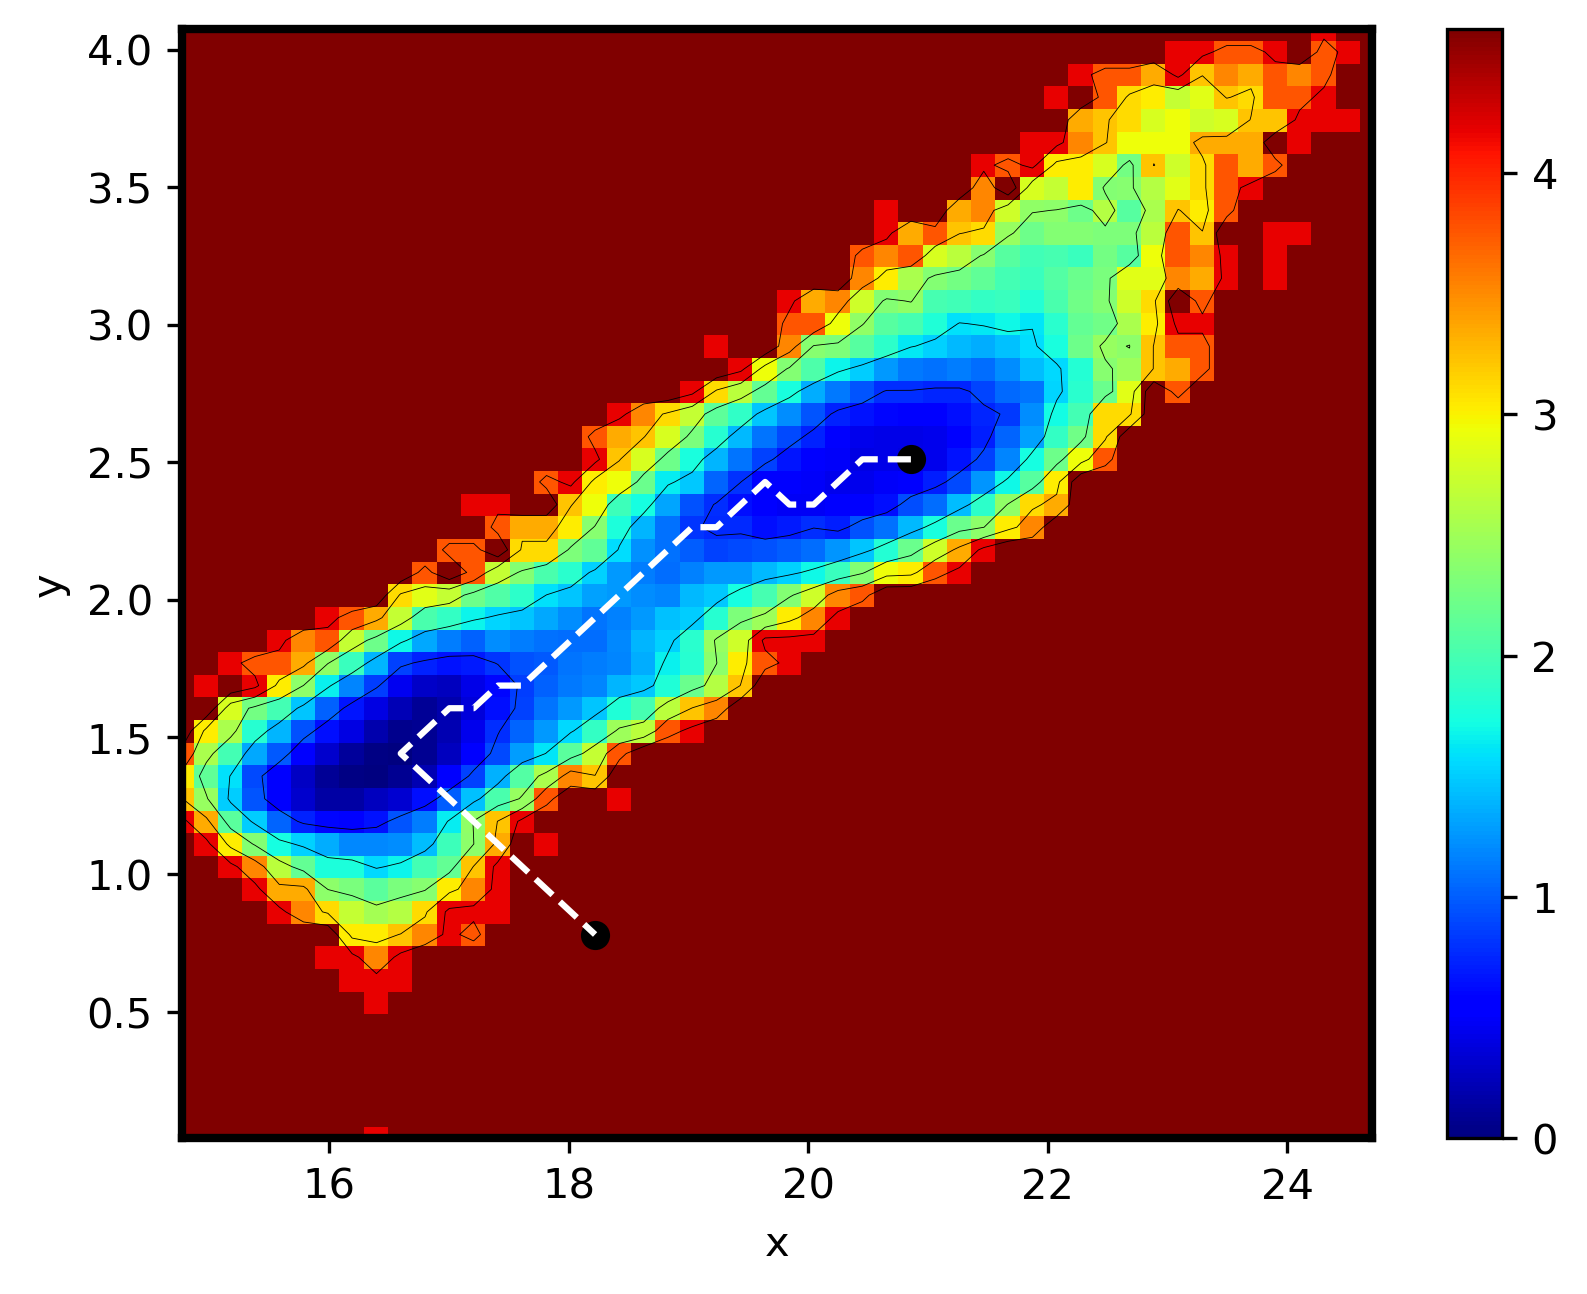

In [104]:
drawPATH(myP.mesh2d,myG[0].T,"jet",traj, traj[::50],myPeak.ij,"x", "y")

In [105]:
def drawPATH(mehs2d,gbbis,cname,traj, select_traj,ij,xlabel, ylabel):
    # 绘制概率密度曲线
    fig,ax = plt.subplots(dpi=300)
    # 设置边框
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    ax.set_xlim(mehs2d.x.min(),mehs2d.x.max())
    ax.set_ylim(mehs2d.y.min(),mehs2d.y.max())
    ax.set_xlabel("{}".format(xlabel))
    ax.set_ylabel("{}".format(ylabel))

    C=plt.contour(mehs2d.x,mehs2d.y,gbbis,5,colors='black',linewidths= 0.2)  #生成等值线图
    plt.contourf(mehs2d.x,mehs2d.y,gbbis,5,alpha=0.2)
    Pcolor= plt.pcolor(mehs2d.x,mehs2d.y,gbbis
                       ,shading='auto',cmap=cname
                       ,norm = colors.TwoSlopeNorm(vmin=gbbis.min(), vcenter=(gbbis.max()-gbbis.min())/2, vmax=gbbis.max()))
    plt.colorbar(Pcolor)
    x_ = [mehs2d.x[i[0]] for i in traj]
    y_ = [mehs2d.y[i[1]] for i in traj]
    plt.plot(x_,y_,color = "white", linestyle = "--", linewidth = 1.5)
    plt.scatter([mehs2d.x[ij[0][0]], mehs2d.x[ij[1][0]] ] 
                , [mehs2d.y[ij[0][1]], mehs2d.y[ij[1][1]]]
                ,c = "black")
    #for i in select_traj:
    #    plt.scatter([mehs2d.x[i[0]]], [mehs2d.y[i[1]]], c = "black")



In [106]:
draw2DScatterCircle(mydata,myPeak, 0.5, "1","x","y")

NameError: name 'draw2DScatterCircle' is not defined

In [ ]:
# 以下是绘图部分
## 全局字体设置
plt.rcParams["axes.labelweight"] ="bold"
plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.weight"]="bold"
plt.rcParams["font.size"]=20

def draw2DGibbs(xyz,cname,peak, outname, xlabel, ylabel):
    # 绘制概率密度曲线
    X,Y,Z = xyz
    fig,ax = plt.subplots(dpi=300)
    # 设置边框
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    ax.set_xlim(X.min(),X.max())
    ax.set_ylim(Y.min(),Y.max())
    ax.set_xlabel("{}".format(xlabel))
    ax.set_ylabel("{}".format(ylabel))
    C=plt.contour(X,Y,Z,5,colors='black',linewidths= 0.2)  #生成等值线图
    plt.contourf(X,Y,Z,5,alpha=0.2)
    Pcolor= plt.pcolor(X, Y, Z
                       ,shading='auto',cmap=cname
                       ,norm = colors.TwoSlopeNorm(vmin=Z.min(), vcenter=(Z.max()-Z.min())/2, vmax=Z.max()))
    plt.colorbar(Pcolor)
    plt.scatter(peak.x,peak.y,color = "black",s = 6)

    plt.savefig("{}.jpg".format(outname))

## 用于绘制散点-时间分布
def draw2DScatterTime(md2ddat,outname,xlabel,ylabel):
    fig,ax = plt.subplots(dpi=300)
    # 设置边框
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.set_xlabel("{}".format(xlabel))
    ax.set_ylabel("{}".format(ylabel))
    ax.set_xlim(md2ddat.x.min(),md2ddat.x.max())
    ax.set_ylim(md2ddat.y.min(),md2ddat.y.max())
    plt.scatter(md2ddat.x,md2ddat.y,alpha = 0.7,s= 5,c=md2ddat.time)
    cbar = plt.colorbar()
    cbar.set_label('Time (ns)')
 
    plt.savefig("{}.tiff".format(outname))
    plt.savefig("{}.jpg".format(outname))

def draw2DScatterCircle(md2ddat,myPeak, cutoff, outname,xlabel,ylabel):


    fig,ax = plt.subplots(dpi=300)
    # 设置边框
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    ax.set_xlabel("{}".format(xlabel))
    ax.set_ylabel("{}".format(ylabel))

    ax.set_xlim(md2ddat.x.min(),md2ddat.x.max())
    ax.set_ylim(md2ddat.y.min(),md2ddat.y.max())

    plt.scatter(md2ddat.x,md2ddat.y,alpha = 0.7,s= 5)
    # 绘制峰值点:
    for i,x_ in enumerate(myPeak.x):
        plt.scatter(x_,myPeak.y[i],color = "black")
        plt.text(x_,myPeak.y[i],s="P{}".format(i))
        # 并绘制cutoff
        draw_circle = plt.Circle((x_,myPeak.y[i]),cutoff,fill=False)
        plt.gcf().gca().add_artist(draw_circle)


In [ ]:
def InPeakIndex(func):
    def wapper(ss):
        s = ss.rstrip("\n").split(",")
        out = [eval(i) for i in s]
        return out

# 用于从终端获取哪些峰值点需要被删除
@InPeakIndex
def GInDelPeakIndex():
    ss = input("Index: ")
    